In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
from scipy.stats import norm, skewnorm
%matplotlib inline

baselinelevel 117.26089769748987
nlevel 500.0
factor 10.75188287947051
peakheight 5375.94143974


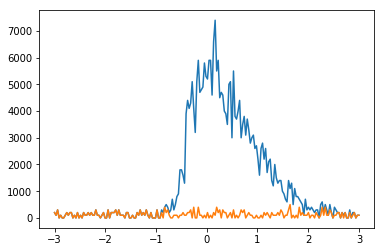

baselinelevel 5312.257079690064
nlevel 3900.0
factor 10.595565232320793
peakheight 41322.7044061


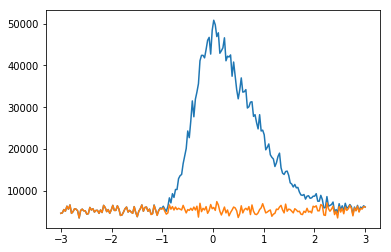

baselinelevel 6.111675228326294
nlevel 100.0
factor 5.571369732228544
peakheight 557.136973223


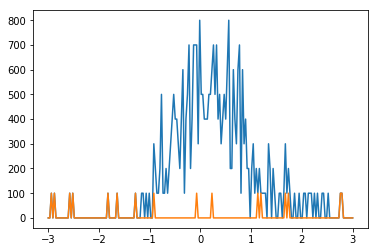

baselinelevel 205.30534480163234
nlevel 700.0
factor 4.538519579185763
peakheight 3176.96370543


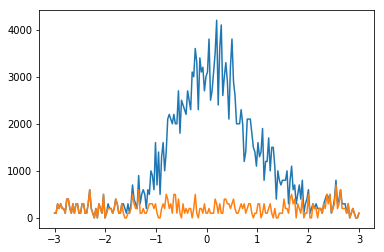

baselinelevel 3.3559872246571443
nlevel 100.0
factor 9.541105905752369
peakheight 954.110590575


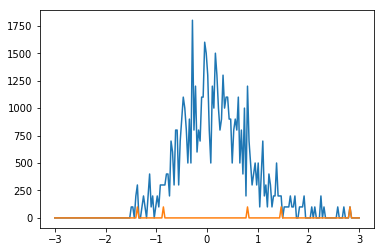

baselinelevel 603.5982384263675
nlevel 1300.0
factor 5.776332729667027
peakheight 7509.23254857


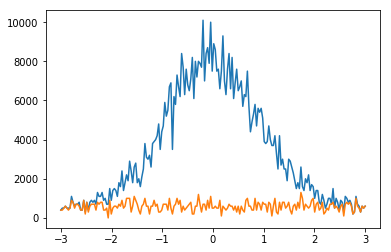

baselinelevel 2100.217321871601
nlevel 3000.0
factor 10.092408555308674
peakheight 30277.2256659


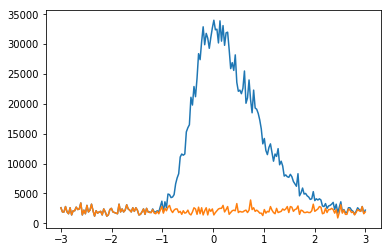

baselinelevel 237.1354078840851
nlevel 700.0
factor 6.268916463264305
peakheight 4388.24152429


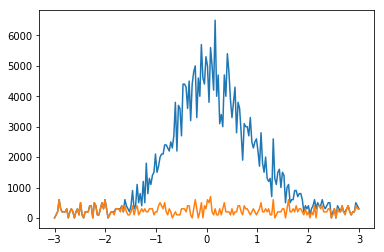

baselinelevel 299.93268546631316
nlevel 1200.0
factor 10.345006165762587
peakheight 12414.0073989


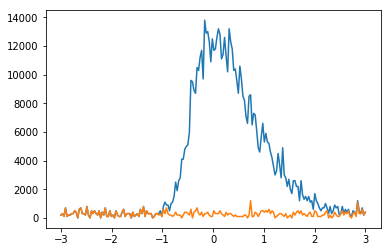

baselinelevel 10958.345482786483
nlevel 5000.0
factor 10.824423482412813
peakheight 54122.1174121


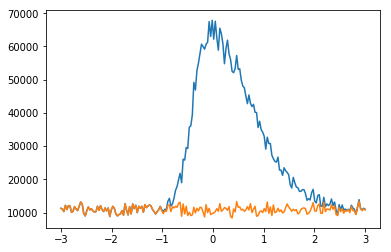

In [71]:
class peakmodel:
    @classmethod
    def spikenoise(cls, length, maxintensity):
        data = np.arange(length)
        print(data)
        return data
    @classmethod
    def peak(cls, maxcps, datapoints, dwelltime, skew = 0, sigma = 3, location = 0):
        location = 0
        scale = 1
        alpha = skew
#         delta = alpha / np.sqrt(1+alpha**2)
#         uz = np.sqrt(2/np.pi) * delta
#         sigmaz = np.sqrt(1.0-uz**2.0)
#         gamma = (4-np.pi)/2 * (delta*np.sqrt(2/np.pi))**3/(1-2*delta**2/np.pi)**(3/2)
#         moa = uz - (gamma * sigmaz / 2) - (np.sign(alpha))*np.exp(-2*np.pi/np.abs(alpha))
#         mode = location + scale * moa
#         _norm_ = skewnorm.pdf(x=mode, a=alpha, loc=location, scale=scale) # 標準正規分布の高さ

        times = np.linspace(-sigma, sigma, datapoints)                
        _refpeak_ = [skewnorm.pdf(x = time, a=alpha, loc=0, scale=scale) for time in times]
        _norm_ = np.max(_refpeak_)
        maxindex = np.argmax(_refpeak_)
        maxtime = times[maxindex]
        # refpeak = np.array(_refpeak_) * maxcps / _norm_
        refpeak = np.array([skewnorm.pdf(x=time, a=alpha, loc= location - maxtime, scale=scale) * maxcps / _norm_ for time in times])
        # print('maxindex:', maxindex)
        # print('maxpos:', maxtime)
        samplepeak = np.array([poisson(peak * dwelltime / 1000) * 1000 / dwelltime for peak in refpeak])
        return times, refpeak, samplepeak    
    @classmethod
    def baseline(cls, level, datapoints, dwelltime):
        sample = np.array([poisson(level * dwelltime / 1000) * 1000 / dwelltime for i in np.arange(datapoints)])
        variation = np.max(sample) - np.min(sample)
        
        return sample, variation
    @classmethod
    def spikenoise(cls, datapoints):
        sample = np.array([poisson(1) for i in np.arange(datapoints)])
        # print(sample)
        return sample
        
# noise = baselinenoise()
# peakmodel.spikenoise(10, 1)
for i in np.arange(10):
    baselinelevel = 10**(rand() * 5)
    base, noiselevel = peakmodel.baseline(level= baselinelevel, datapoints= 200, dwelltime=10)
    print('baselinelevel', baselinelevel)
    print('nlevel', noiselevel)
    #peakheight = 2 + rand() * 3    
    factor = 3 + rand() * 10
    print('factor', factor)
    peakheight = np.max([noiselevel, 10]) * factor
    skw = rand() * 5
    #peakheight = 10**peakheight
    print('peakheight', peakheight)
    times, refpeak, samplepeak = peakmodel.peak(maxcps = peakheight, datapoints = 200, dwelltime = 10, skew=skw)
    #spike = peakmodel.spikenoise(datapoints = 200) * peakheight / 30
    sample_with_noise = samplepeak + base
#     plt.plot(times, refpeak + baselinelevel)
    plt.plot(times, sample_with_noise)
    plt.plot(times, base)
    plt.show()
